In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install matplotlib seaborn torch pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 27.1 MB/s eta 0:00:00


In [66]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
import pyro.poutine as poutine
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os, json
from datetime import datetime



In [ ]:
import pandas as pd
import numpy as np
import sys
import os

root = '/content/drive/MyDrive/PMML_Project'
data_path = root +"/Dataset/Click_Subsample"
utils_path = root +"/utils"

if root not in sys.path:
    sys.path.insert(0, root)


if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

print("✅ Imports successful!")


✅ Imports successful!


In [ ]:
with open("/content/drive/MyDrive/PMML_Project/model.py", "r") as f:
    print(f.read())


import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine
import torch.nn.functional as F




class FilteringGuideNet(nn.Module):
    def __init__(self, input_dim, x_dim, latent_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + input_dim + x_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

    def forward(self, z_prev, A_t, X_t):
        h = torch.cat([z_prev, A_t, X_t], dim=-1)
        mu, logvar = self.net(h).chunk(2, dim=-1)
        return mu, logvar



class PyroDVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, x_dim):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # ---------- Generative model ----------
        # Transi

In [ ]:
import sys, importlib
sys.path.append("/content/drive/MyDrive/PMML_Project")

import model
importlib.reload(model)

print("PyroDVAE" in dir(model))

from model import PyroDVAE


True


In [ ]:
from util import train_dvae_with_diagnostics, linear_anneal, _get_elbo_components

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [78]:
from Preprocessing import process_alibaba_data, behaviors_to_X_window, exposure_table_to_tensor, user_process, save_input, to_tensor
from util import make_fixed_user_mask, make_time_varying_user_mask
from Evaluation import ppc_discrepancy_per_user, extract_posterior_mean_Z, save_run, predictive_score, summarize_mask
from Evaluation import plot_ppc_kde, compute_predictive_scores_per_time, compute_predictive_scores, ppc_discrepancy_time_indexed, plot_posterior_and_prior_variance
import matplotlib.pyplot as plt
from Evaluation import plot_ppc_kde_per_day

### Load Data and Preprocessing

In [75]:
sample = pd.read_csv(data_path+"/samples.csv")
behaviors = pd.read_csv(data_path+"/behavior_log.csv")
behaviors = pd.get_dummies(behaviors, columns=["btag"], prefix="behav_")
user = pd.read_csv(data_path+"/users.csv")
feature = pd.read_csv(data_path+"/features.csv")
sample_cate = pd.read_csv(data_path+"/exposure.csv")


In [79]:
A, users, timesteps, categories = process_alibaba_data(sample_cate)

Data shape: 10668 users x 7 timesteps x 2745 categories


In [80]:
user_static_cols = [
    "final_gender_code",
    "age_level",
    "shopping_level",
    "occupation",
    "cms_segid"
]
behav_cols = ["behav__pv", "behav__cart", "behav__fav"]

user_static = user[["userid"] + user_static_cols].copy()
lag_cols = [f"{c}_lag1" for c in ["pv_count", "cart_count", "fav_count", "distinct_cate"]]


In [82]:
users_all = user["userid"].tolist()
user2idx = {u:i for i,u in enumerate(users_all)}
U = len(users_all)

all_cates = sorted(sample_cate["cate_id"].unique())
cate2idx = {c:i for i,c in enumerate(all_cates)}
D = len(cate2idx)


exposure = sample_cate.copy()

exposure["date"] = pd.to_datetime(
    exposure["time_stamp"],
    errors="coerce"
).dt.date

dates_all = sorted(exposure["date"].unique())
date2idx = {d: i for i, d in enumerate(dates_all)}

T = len(dates_all)
print(U,T,D)

12000 9 2896


In [83]:
print("min exposure date:", exposure["date"].min())
print("max exposure date:", exposure["date"].max())

print("first 5 dates_all:", dates_all[:5])
print("last 5 dates_all:", dates_all[-5:])

print("dates in exposure but not in dates_all:",
      set(exposure["date"].unique()) - set(dates_all))


min exposure date: 2017-05-05
max exposure date: 2017-05-13
first 5 dates_all: [datetime.date(2017, 5, 5), datetime.date(2017, 5, 6), datetime.date(2017, 5, 7), datetime.date(2017, 5, 8), datetime.date(2017, 5, 9)]
last 5 dates_all: [datetime.date(2017, 5, 9), datetime.date(2017, 5, 10), datetime.date(2017, 5, 11), datetime.date(2017, 5, 12), datetime.date(2017, 5, 13)]
dates in exposure but not in dates_all: set()


In [87]:
## Prepare training data
exposure_start = pd.to_datetime("2017-05-05").date()
exposure_end   = pd.to_datetime("2017-05-13").date()
X_df,lag_cols, dates_window = behaviors_to_X_window(
    behaviors,
    behav_cols,
    users_all,
    user2idx,
    exposure_start,
    exposure_end)


(12000, 9, 4)


In [88]:
A_all = exposure_table_to_tensor(
    exposure,
    users_all, user2idx,
    cate2idx,
    dates_all, date2idx
)

print(A_all.shape)


ui NaN rate: 0.0
ti NaN rate: 0.0
ci NaN rate: 0.0
torch.Size([12000, 9, 2896])


In [89]:
A_tensor, X_tensor = user_process(A_all, X_df, users_all)
print(A_tensor.shape, X_tensor.shape)

torch.Size([12000, 9, 2896]) (12000, 9, 108)


In [90]:
A_train, X_train = A_tensor[:, 0:7, :], X_tensor[:, 0:7, :]
A_val, X_val = A_tensor[:, 7:8, :], X_tensor[:, 7:8, :]
A_held, X_held = A_tensor[:, 8:9, :], X_tensor[:, 8:9, :]
print(A_train.shape, X_train.shape)
print(A_val.shape, X_val.shape)
print(A_held.shape, X_held.shape)

torch.Size([12000, 7, 2896]) (12000, 7, 108)
torch.Size([12000, 1, 2896]) (12000, 1, 108)
torch.Size([12000, 1, 2896]) (12000, 1, 108)


In [91]:
save_input(A_train, X_train, "train")
save_input(A_val, X_val, "val")
save_input(A_held, X_held, "test")

In [108]:
device = "cuda"

A_tensor, X_tensor = to_tensor(A_tensor, X_tensor)
A_train, X_train = to_tensor(A_train, X_train)
A_val, X_val = to_tensor(A_val,X_val)
A_held, X_held = to_tensor(A_held,X_held)


torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision("high")

A_try = A_tensor.clone()
A_try = torch.clamp(A_try, max=15.0)


/tmp/ipython-input-2553307739.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A_tensor = torch.tensor(A_tensor, dtype=torch.float32, device=device)


<class 'torch.Tensor'> cuda:0
<class 'torch.Tensor'> cuda:0
torch.Size([12000, 9, 2896]) torch.Size([12000, 9, 108])
<class 'torch.Tensor'> cuda:0
<class 'torch.Tensor'> cuda:0
torch.Size([12000, 7, 2896]) torch.Size([12000, 7, 108])
<class 'torch.Tensor'> cuda:0
<class 'torch.Tensor'> cuda:0
torch.Size([12000, 1, 2896]) torch.Size([12000, 1, 108])
<class 'torch.Tensor'> cuda:0
<class 'torch.Tensor'> cuda:0
torch.Size([12000, 1, 2896]) torch.Size([12000, 1, 108])


/tmp/ipython-input-2553307739.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_tensor, dtype=torch.float32, device=device)


### Model

### Experiment 1


Randomly masking the same subset of causes across time. And predict these.

In [99]:
train_kwargs = dict(
    num_epochs=120,
    batch_size=256,
    lr=1e-4,
    anneal="linear",
    warmup_epochs=30,
    device="cuda",
)


In [ ]:
# 1) Create fixed per-user mask
U, T, D = A_try.shape
obs_mask = make_fixed_user_mask(
    U=U,
    T=T,
    D=D,
    holdout_frac=0.10,
    seed=0,
    device=A_try.device,
)


In [ ]:
# Instantiate the DVAE model
model_obj = PyroDVAE(
    input_dim=A_try.shape[2],      # number of causes D
    x_dim=X_tensor.shape[2],           # number of covariates
    latent_dim=200,                     # your chosen latent size
    hidden_dim=128,
)

B = 8
A_b = A_tensor[:B]
X_b = X_tensor[:B]
M_b = obs_mask[:B]

pyro.clear_param_store()
m = model_obj.to(A_b.device)

# One forward to ensure shapes work
tr = poutine.trace(m.model).get_trace(A_b, X_b, M_b, beta=1.0)
tr.compute_log_prob()
print("OK, model trace computed.")


OK, model trace computed.


In [ ]:
optimizer = Adam({"lr": 1e-4})
svi = SVI(
    lambda A, X, M: model_obj.model(A, X, obs_mask=M, beta=1.0),
    lambda A, X, M: model_obj.guide(A, X, obs_mask=M, beta=1.0),
    optimizer,
    loss=Trace_ELBO(),
)


loss = svi.step(A_b, X_b, M_b)
print("SVI loss:", loss)


SVI loss: 134249.57006835938


[Epoch 10/120] beta=0.333 loss=-561630.67 KL=-603688.11 var=4.7829
[Epoch 20/120] beta=0.667 loss=-247667.51 KL=-277615.13 var=5.5079
[Epoch 30/120] beta=1.000 loss=66114.88 KL=35106.14 var=3.0780
[Epoch 40/120] beta=1.000 loss=48732.24 KL=19405.54 var=2.1298
[Epoch 50/120] beta=1.000 loss=42054.52 KL=14240.89 var=1.8161
[Epoch 60/120] beta=1.000 loss=38101.24 KL=11262.60 var=1.6452
[Epoch 70/120] beta=1.000 loss=35329.49 KL=9159.72 var=1.5314
[Epoch 80/120] beta=1.000 loss=33270.69 KL=7713.22 var=1.4477
[Epoch 90/120] beta=1.000 loss=31300.43 KL=6568.57 var=1.3596
[Epoch 100/120] beta=1.000 loss=29611.63 KL=5712.34 var=1.2801
[Epoch 110/120] beta=1.000 loss=28379.42 KL=5098.76 var=1.2184
[Epoch 120/120] beta=1.000 loss=27496.05 KL=4634.85 var=1.1725


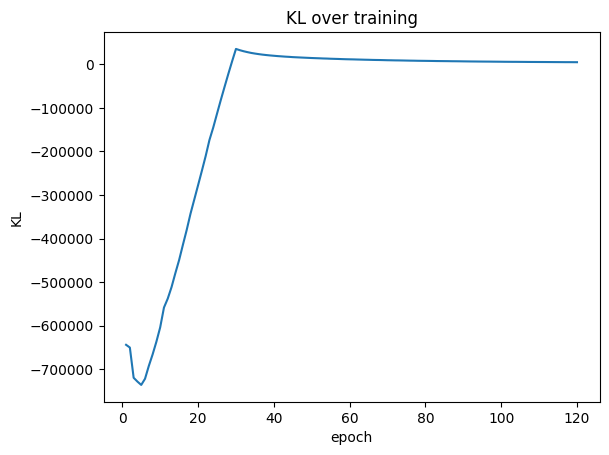

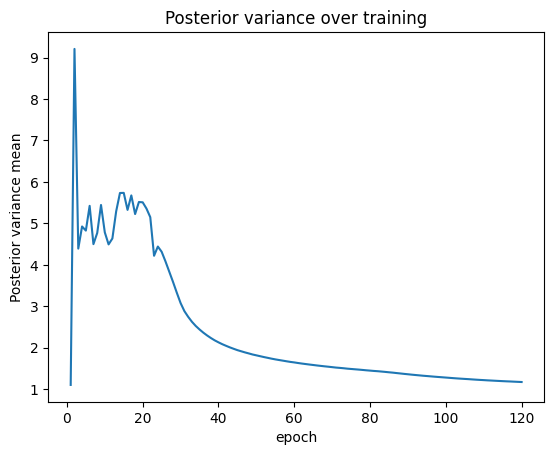

In [ ]:
df_mask_fix = train_dvae_with_diagnostics(
    model_obj,
    A_try,
    X_tensor,
    obs_mask = obs_mask,
    **train_kwargs,

)


In [ ]:
model_config = dict(
    input_dim=A_tensor.shape[2],
    x_dim=X_tensor.shape[2],
    latent_dim=200,
    hidden_dim=128,
)

out_dir = save_run(
    save_dir="/content/drive/MyDrive/PMML_Project/experiments",
    run_name="dvae_fixed_mask",
    model_obj=model_obj,
    train_df=df_mask_fix,
    obs_mask=obs_mask,              # ★关键
    train_kwargs=train_kwargs,
    model_config=model_config,
    extra_meta={
        "mask_type": "fixed_per_user",
        "holdout_ratio": 0.1,
        "mask_seed": 0,
    }
)


Saved to: /content/drive/MyDrive/PMML_Project/experiments/dvae_fixed_mask_20251216_105607


#### PPC

In [ ]:
summarize_mask(obs_mask)


Held-out ratio overall: 0.1001381203532219
Held-out causes per user (min/mean/max): 290.0 290.0 290.0
Mask inconsistent across time: False


In [ ]:
t_obs, t_rep = ppc_discrepancy_per_user(model_obj=model_obj,
    A=A_tensor,
    X=X_tensor,
    obs_mask=obs_mask,
    num_z_samples=50,
    batch_size=128,
)

In [72]:
print(t_rep.shape)
print(t_obs.shape)

torch.Size([12000, 9, 50])
torch.Size([12000, 9])


In [74]:
# current shapes:
# t_obs: (U, T)
# t_rep: (U, T, S)

t_obs_user = t_obs.sum(dim=1)          # (U,)
t_rep_user = t_rep.sum(dim=1)          # (U, S)

score = predictive_score(t_obs_user, t_rep_user)

print("PPC predictive score:", score)
print("Mean t_obs:", t_obs)
print("Mean t_rep:", t_rep)


PPC predictive score: 1.0
Mean t_obs: tensor([[-203.7733, -203.3771, -203.2401,  ..., -203.6302, -203.0135,
         -203.7523],
        [-202.2205, -202.1029, -202.0817,  ..., -202.2739, -202.6310,
         -202.0777],
        [-200.5521, -200.6149, -200.2448,  ..., -200.3924, -200.5034,
         -200.4528],
        ...,
        [-202.4366, -202.6224, -202.9793,  ..., -202.3940, -202.7001,
         -202.7227],
        [-200.1376, -199.9444, -200.2011,  ..., -200.2740, -200.3571,
         -201.0801],
        [-200.8792, -200.5806, -201.4830,  ..., -201.0173, -201.0585,
         -201.2433]])
Mean t_rep: tensor([[[-340.4700, -317.2836, -323.8696,  ..., -339.0079, -320.3175,
          -303.5360],
         [-307.9492, -314.3675, -311.9648,  ..., -321.7462, -314.3627,
          -339.6469],
         [-314.9960, -311.5865, -303.2233,  ..., -330.3926, -309.7329,
          -317.2692],
         ...,
         [-324.3024, -316.3828, -331.5116,  ..., -314.4809, -309.8393,
          -323.3394],
    

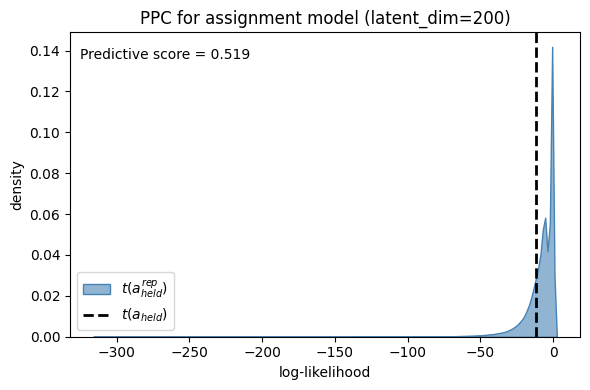

In [ ]:
plot_ppc_kde(
    t_obs,
    t_rep,
    ppc_score=score,
    title=f"PPC for assignment model (latent_dim={200})"
)

### Experiment 2

Randomly mask different subsets of causes across time. And predict these

In [ ]:
train_kwargs = dict(
    num_epochs=150,
    batch_size=256,
    lr=1e-4,
    anneal="linear",
    warmup_epochs=30,
    device="cuda",
)

In [103]:
obs_mask_B = make_time_varying_user_mask(U, T, D, holdout_frac=0.10)


In [121]:
model_obj

PyroDVAE(
  (transition): Sequential(
    (0): Linear(in_features=3204, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=400, bias=True)
  )
  (emission): Sequential(
    (0): Linear(in_features=308, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2896, bias=True)
  )
  (guide_transition): FilteringGuideNet(
    (net): Sequential(
      (0): Linear(in_features=3204, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=400, bias=True)
    )
  )
  (z1_encoder): Sequential(
    (0): Linear(in_features=3004, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=400, bias=True)
  )
)

OK, model trace computed.
[Epoch 10/150] beta=0.333 loss=-576746.92 KL=-605396.74 var=5.8339
[Epoch 20/150] beta=0.667 loss=-246522.80 KL=-277989.49 var=5.1981
[Epoch 30/150] beta=1.000 loss=65387.11 KL=34209.55 var=3.0045
[Epoch 40/150] beta=1.000 loss=49289.51 KL=19914.73 var=2.1409
[Epoch 50/150] beta=1.000 loss=42684.31 KL=14633.93 var=1.8274
[Epoch 60/150] beta=1.000 loss=38650.45 KL=11519.37 var=1.6488
[Epoch 70/150] beta=1.000 loss=35771.76 KL=9382.82 var=1.5326
[Epoch 80/150] beta=1.000 loss=33726.36 KL=7827.16 var=1.4476
[Epoch 90/150] beta=1.000 loss=32070.53 KL=6697.16 var=1.3824
[Epoch 100/150] beta=1.000 loss=30394.86 KL=5974.42 var=1.3273
[Epoch 110/150] beta=1.000 loss=28853.88 KL=5434.51 var=1.2732
[Epoch 120/150] beta=1.000 loss=27775.27 KL=4884.86 var=1.2203
[Epoch 130/150] beta=1.000 loss=26906.95 KL=4399.30 var=1.1684
[Epoch 140/150] beta=1.000 loss=26179.43 KL=4025.14 var=1.1201
[Epoch 150/150] beta=1.000 loss=25532.49 KL=3658.09 var=1.0765


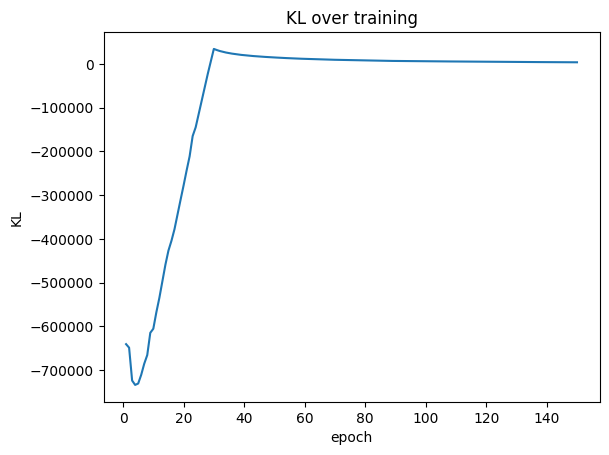

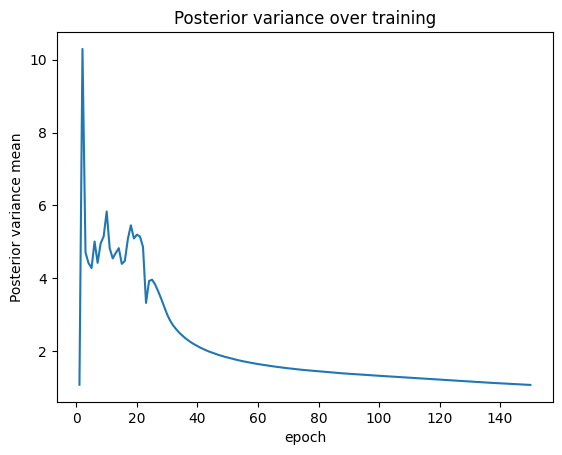

In [120]:
# Instantiate the DVAE model
model_obj = PyroDVAE(
    input_dim=A_try.shape[2],      # number of causes D
    x_dim=X_tensor.shape[2],           # number of covariates
    latent_dim=200,                     # your chosen latent size
    hidden_dim=128,
)

B = 8
A_b = A_tensor[:B]
X_b = X_tensor[:B]
M_b = obs_mask_B[:B]

pyro.clear_param_store()
m = model_obj.to(A_b.device)

# One forward to ensure shapes work
tr = poutine.trace(m.model).get_trace(A_b, X_b, M_b, beta=1.0)
tr.compute_log_prob()
print("OK, model trace computed.")


train_kwargs = dict(
    num_epochs=150,
    batch_size=256,
    lr=1e-4,
    anneal="linear",
    warmup_epochs=30,
    device="cuda",
)


df_mask = train_dvae_with_diagnostics(
    model_obj,
    A_try,
    X_tensor,
    obs_mask = obs_mask_B,
    **train_kwargs,
)



In [124]:
t_obs, t_rep = ppc_discrepancy_per_user(model_obj=model_obj,
    A=A_tensor,
    X=X_tensor,
    obs_mask=obs_mask_B,
    num_z_samples=50,
    batch_size=128,
)

score_B = predictive_score(t_obs, t_rep)

print("PPC predictive score:", score_B)
print("Mean t_obs:", t_obs)
print("Mean t_rep:", t_rep)


PPC predictive score: 0.4727233350276947
Mean t_obs: tensor([ -0.8072,  -0.6324,  -1.9647,  ..., -12.3517,  -4.4191,  -0.9213])
Mean t_rep: tensor([[-11.2824,  -1.1720,  -6.4941,  ...,  -0.2410, -22.6886,  -7.3420],
        [ -0.2957, -13.2160,  -8.6590,  ...,  -0.4021, -10.7746,  -0.3737],
        [ -1.9896,  -1.5069, -13.0227,  ..., -25.4502, -14.7808,  -2.5347],
        ...,
        [ -0.4428,  -1.2548,  -0.2989,  ...,  -3.0265,  -0.9773,  -4.8943],
        [ -5.3991, -11.4255, -12.4014,  ..., -16.6421, -12.7539, -16.4259],
        [ -0.7948,  -0.2649,  -1.5678,  ..., -10.1931, -14.5726,  -1.1945]])


In [ ]:
t_obs, t_rep = ppc_discrepancy_time_indexed(model_obj=model_obj,
    A=A_tensor,
    X=X_tensor,
    obs_mask=obs_mask_B,
    num_z_samples=30,
    batch_size=128,
)


In [184]:
# Usage example:
p_values = compute_predictive_scores(t_obs, t_rep)
for t, p in enumerate(p_values):
    status = "Satisfactory" if p > 0.1 else "Mismatch Detected"
    print(f"Time {t}: Score = {p:.4f} ({status})")

Time 0: Score = 0.1833 (Satisfactory)
Time 1: Score = 0.1007 (Satisfactory)
Time 2: Score = 0.1040 (Satisfactory)
Time 3: Score = 0.1049 (Satisfactory)
Time 4: Score = 0.1029 (Satisfactory)
Time 5: Score = 0.1022 (Satisfactory)
Time 6: Score = 0.1061 (Satisfactory)
Time 7: Score = 0.1057 (Satisfactory)
Time 8: Score = 0.0990 (Mismatch Detected)


In [ ]:
score_B = predictive_score(t_obs, t_rep)

print("PPC predictive score:", score_B)
print("Mean t_obs:", t_obs)
print("Mean t_rep:", t_rep)


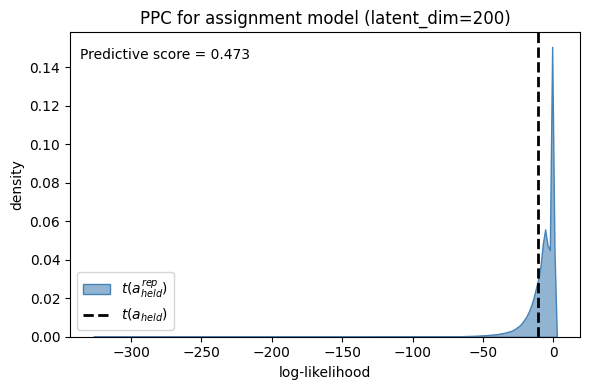

In [128]:
latent_dim=200
plot_ppc_kde(
    t_obs,
    t_rep,
    ppc_score=score_B,
    title=f"PPC for assignment model (latent_dim={latent_dim})"
)


In [142]:
model_config = dict(
    input_dim=A_tensor.shape[2],
    x_dim=X_tensor.shape[2],
    latent_dim=200,
    hidden_dim=128,
)

out =  save_run(
    save_dir="/content/drive/MyDrive/PMML_Project/experiments/",
    run_name="dvae_dynamic_masked",
    model_obj=model_obj,
    A=A_tensor,
    X=X_tensor,
    obs_mask=obs_mask_B,
    train_df=df_mask,
    train_kwargs=train_kwargs,
    model_config=model_config,
    extra_meta={
        "mask_type": "dynamic_per_user",
        "holdout_ratio": 0.1,
        "mask_seed": 0,
        },
    save_rng_state=True,
)

Run saved to: /content/drive/MyDrive/PMML_Project/experiments/dvae_dynamic_masked_20251219_230427


In [140]:
t_obs_time, t_rep_time = ppc_discrepancy_time_indexed(
    model_obj,
    A_tensor,
    X_tensor,
    obs_mask,
    num_z_samples=50,
    batch_size=128,
)

In [152]:
predictive_score_t = (t_rep_time < t_obs_time.unsqueeze(-1)).float().mean(dim=(0, 2))
predictive_score_t

tensor([0.3198, 0.2966, 0.3066, 0.3107, 0.3100, 0.3103, 0.3116, 0.3120, 0.3094])

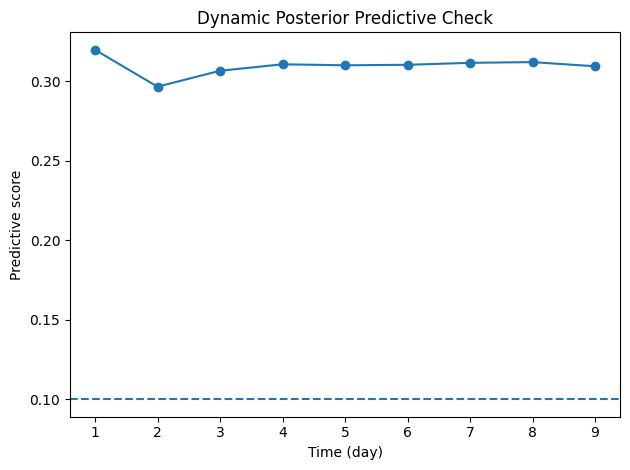

In [280]:
# 1) dynamic PPC
ppc_t = plot_dynamic_ppc(t_obs_time, t_rep_time, threshold=0.1)


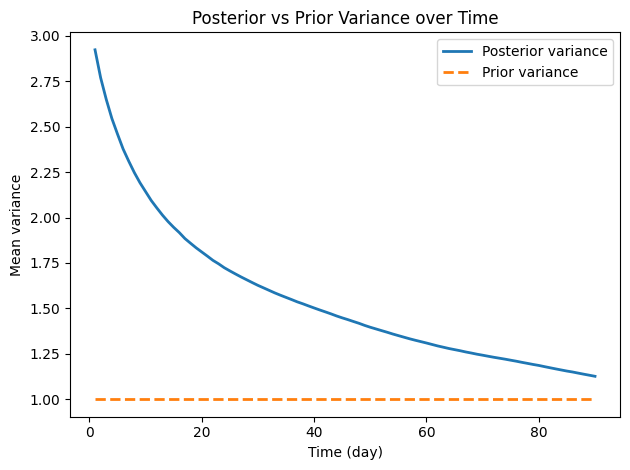

In [150]:
train_df['prior_var_mean'] = 1
# 2) posterior variance
plot_posterior_and_prior_variance(train_df['post_var_mean'].to_list()[30:], train_df['prior_var_mean'].to_list()[30:])


In [259]:
# Run PPC
t_obs, t_rep = ppc_discrepancy_time_indexed(
    model_obj=model_obj,
    A=A_tensor,
    X=X_tensor,
    obs_mask=obs_mask_B,
    num_z_samples=50
)


In [274]:
# Compute scores per time step
scores = compute_predictive_scores_per_time(t_obs, t_rep)

# Print results
print("Predictive scores per time step:")
for t, score in enumerate(scores):
    status = "✓" if score > 0.1 else "✗"
    print(f"  t={t+1}: {score:.3f} {status}")



Predictive scores per time step:
  t=1: 0.320 ✓
  t=2: 0.295 ✓
  t=3: 0.307 ✓
  t=4: 0.310 ✓
  t=5: 0.310 ✓
  t=6: 0.308 ✓
  t=7: 0.310 ✓
  t=8: 0.311 ✓
  t=9: 0.310 ✓


In [278]:
scores

tensor([0.3199, 0.2955, 0.3069, 0.3098, 0.3101, 0.3083, 0.3104, 0.3110, 0.3096])

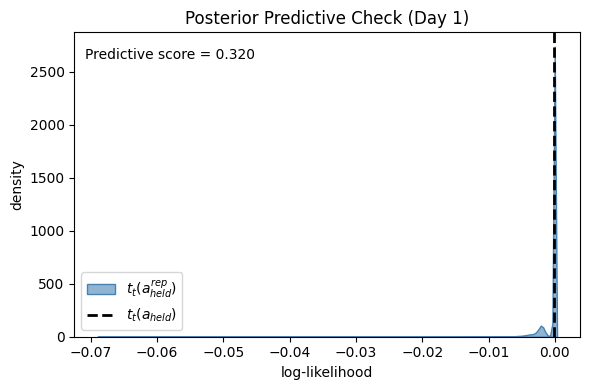

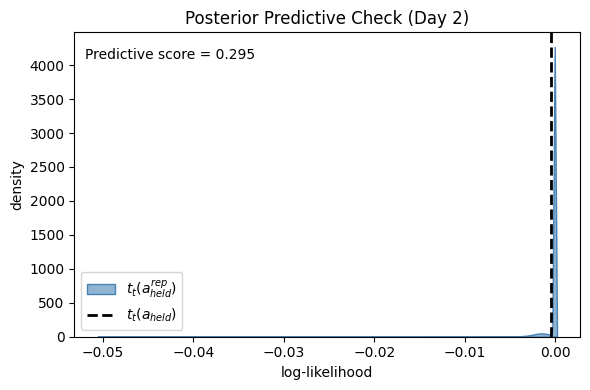

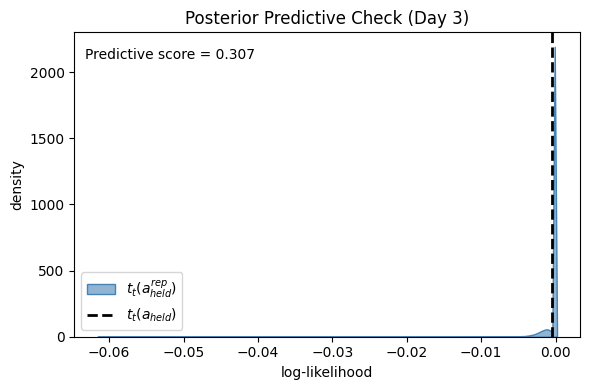

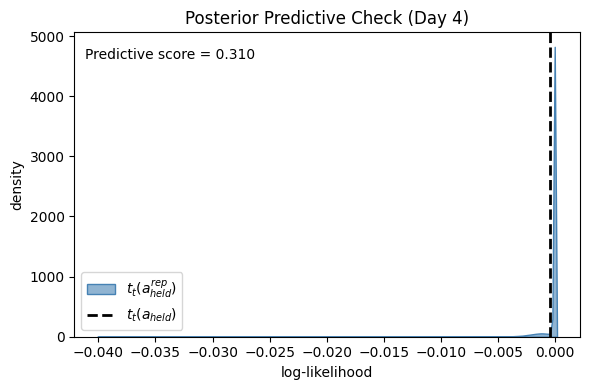

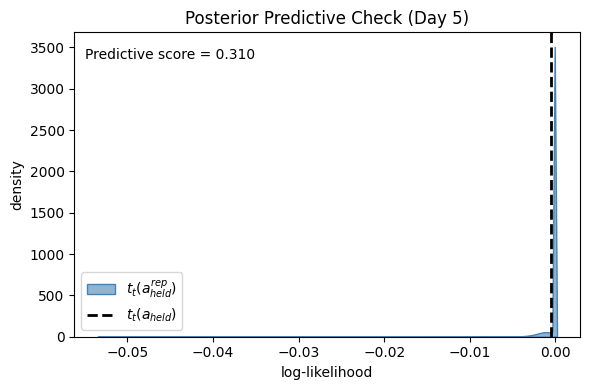

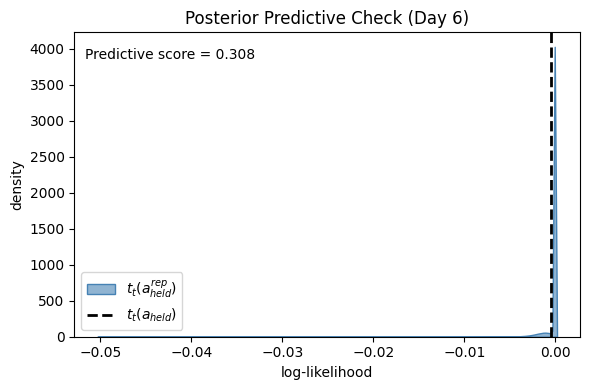

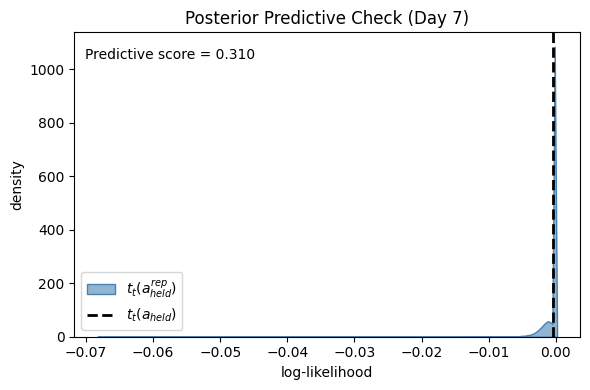

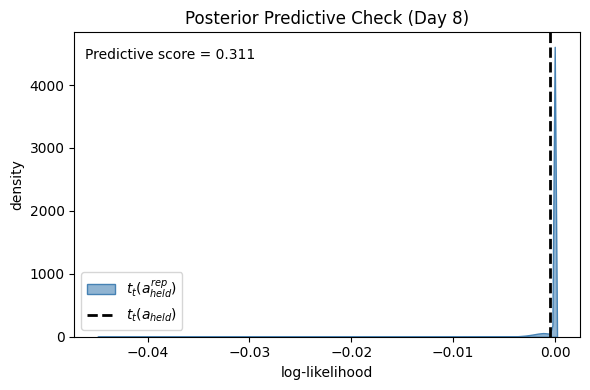

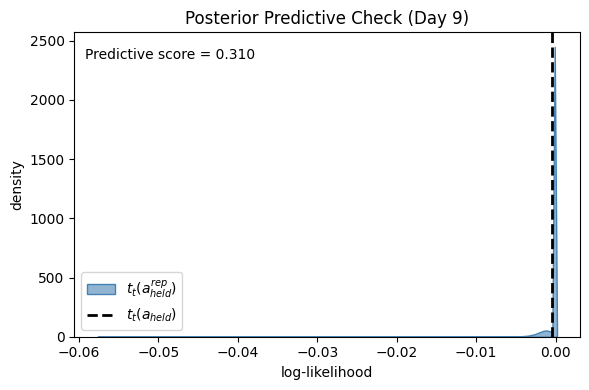

In [277]:
plot_ppc_kde_per_day(
    t_obs,          # (U, T)
    t_rep,          # (U, T, S)
    scores,
    days=None,      # list of day indices to plot
    figsize=(6, 4),
)

### Experiment 3: Latent Dimension

In [ ]:
train_kwargs = dict(
    num_epochs=100,
    batch_size=128,
    lr=1e-4,
    anneal="linear",
    warmup_epochs=30,
    device="cuda",
)


In [ ]:
def run_single_latent_experiment(
    latent_dim,
    A,
    X,
    obs_mask,
    model_kwargs,
    train_kwargs,
    ppc_kwargs,
    seed=0,
):
    pyro.clear_param_store()
    pyro.set_rng_seed(seed)

    # --- Instantiate model ---
    model_obj = PyroDVAE(
        input_dim=model_kwargs["input_dim"],
        x_dim=model_kwargs["x_dim"],
        latent_dim=latent_dim,
        hidden_dim=model_kwargs["hidden_dim"],
    ).to(train_kwargs["device"])

    # --- Sanity forward (cheap, optional) ---
    B = 4
    with torch.no_grad():
        tr = poutine.trace(model_obj.model).get_trace(
            A[:B], X[:B], obs_mask[:B], beta=1.0
        )
        tr.compute_log_prob()

    # --- Train ---
    df_train = train_dvae_with_diagnostics(
        model_obj,
        A,
        X,
        obs_mask=obs_mask,
        **train_kwargs,
    )

    # --- PPC ---
    t_obs, t_rep = ppc_discrepancy_per_user(
        model_obj=model_obj,
        A=A,
        X=X,
        obs_mask=obs_mask,
        **ppc_kwargs,
    )

    score = predictive_score(t_obs, t_rep)

    # --- Collect summary ---
    summary = {
        "latent_dim": latent_dim,
        "ppc_score": score,
        "final_kl": df_train["kl"].iloc[-1],
        "final_post_var": df_train["post_var_mean"].iloc[-1],
        "num_epochs": train_kwargs["num_epochs"],
        "lr": train_kwargs["lr"],
        "anneal": train_kwargs["anneal"],
        "warmup_epochs": train_kwargs["warmup_epochs"],
        "seed": seed,
    }

    return {
        "latent_dim": latent_dim,
        "model": model_obj,
        "train_df": df_train,
        "t_obs": t_obs,
        "t_rep": t_rep,
        "ppc_score": score,
        "summary": summary,
    }


In [ ]:
# 1) Create fixed per-user mask
U, T, D = A_try.shape
obs_mask = make_fixed_user_mask(
    U=U,
    T=T,
    D=D,
    holdout_frac=0.15,
    seed=0,
    device=A_try.device,
)


In [ ]:
latent_grid = [10, 50, 100, 200, 500]


===== Running latent_dim = 10 =====
[Epoch 10/100] beta=0.333 loss=4980.59 KL=-13499.60 var=18.9639
[Epoch 20/100] beta=0.667 loss=10161.96 KL=-4878.75 var=7.7018
[Epoch 30/100] beta=1.000 loss=16228.61 KL=2954.56 var=3.6548
[Epoch 40/100] beta=1.000 loss=13752.11 KL=2051.36 var=1.7266
[Epoch 50/100] beta=1.000 loss=12276.19 KL=1664.26 var=1.1514
[Epoch 60/100] beta=1.000 loss=11548.30 KL=1445.53 var=0.8914
[Epoch 70/100] beta=1.000 loss=11051.85 KL=1262.80 var=0.7238
[Epoch 80/100] beta=1.000 loss=10661.90 KL=1133.12 var=0.6158
[Epoch 90/100] beta=1.000 loss=10296.73 KL=1026.37 var=0.5458
[Epoch 100/100] beta=1.000 loss=9933.90 KL=930.79 var=0.5149


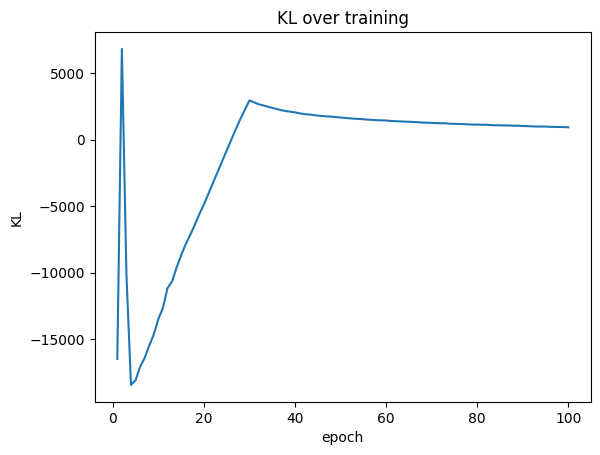

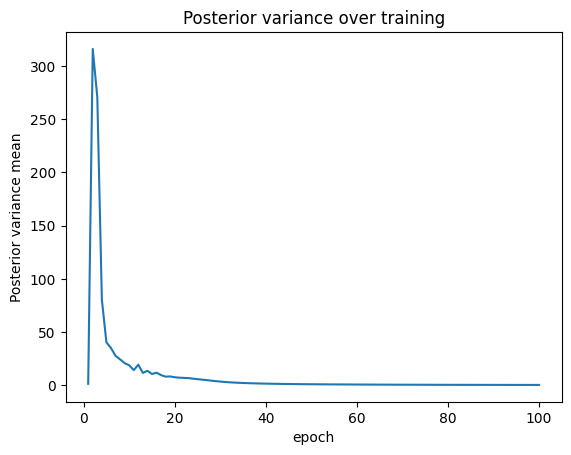

[Z=10] PPC=0.518, KL=930.8, Var=0.5149

===== Running latent_dim = 50 =====
[Epoch 10/100] beta=0.333 loss=-60814.70 KL=-75977.06 var=7.3990
[Epoch 20/100] beta=0.667 loss=-19500.65 KL=-33817.66 var=6.1809
[Epoch 30/100] beta=1.000 loss=17992.16 KL=4496.23 var=3.4402
[Epoch 40/100] beta=1.000 loss=14849.34 KL=2590.68 var=2.1380
[Epoch 50/100] beta=1.000 loss=13130.79 KL=2006.46 var=1.6232
[Epoch 60/100] beta=1.000 loss=12226.60 KL=1727.40 var=1.3183
[Epoch 70/100] beta=1.000 loss=11663.24 KL=1511.24 var=1.1312
[Epoch 80/100] beta=1.000 loss=11166.91 KL=1315.08 var=1.0070
[Epoch 90/100] beta=1.000 loss=10740.25 KL=1153.52 var=0.9335
[Epoch 100/100] beta=1.000 loss=10308.39 KL=1008.19 var=0.8957


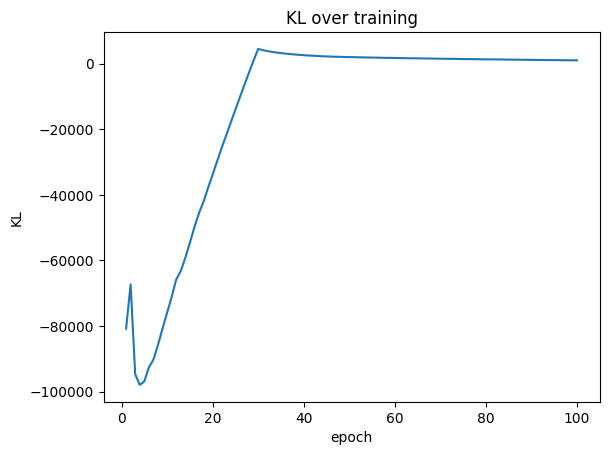

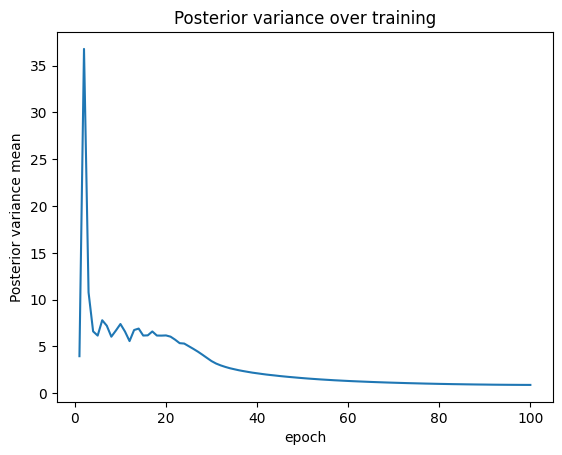

[Z=50] PPC=0.526, KL=1008.2, Var=0.8957

===== Running latent_dim = 100 =====
[Epoch 10/100] beta=0.333 loss=-139820.52 KL=-153403.47 var=6.8864
[Epoch 20/100] beta=0.667 loss=-55210.16 KL=-69576.91 var=5.4734
[Epoch 30/100] beta=1.000 loss=21003.26 KL=7258.43 var=2.8975
[Epoch 40/100] beta=1.000 loss=16663.15 KL=3941.87 var=2.0460
[Epoch 50/100] beta=1.000 loss=14838.82 KL=2778.82 var=1.7271
[Epoch 60/100] beta=1.000 loss=13440.15 KL=2226.52 var=1.5185
[Epoch 70/100] beta=1.000 loss=12446.95 KL=1891.41 var=1.3290
[Epoch 80/100] beta=1.000 loss=11850.87 KL=1613.19 var=1.1971
[Epoch 90/100] beta=1.000 loss=11339.50 KL=1352.30 var=1.1133
[Epoch 100/100] beta=1.000 loss=10858.30 KL=1165.40 var=1.0628


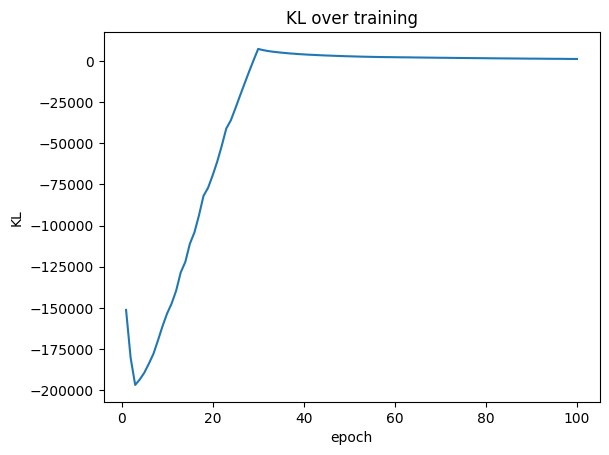

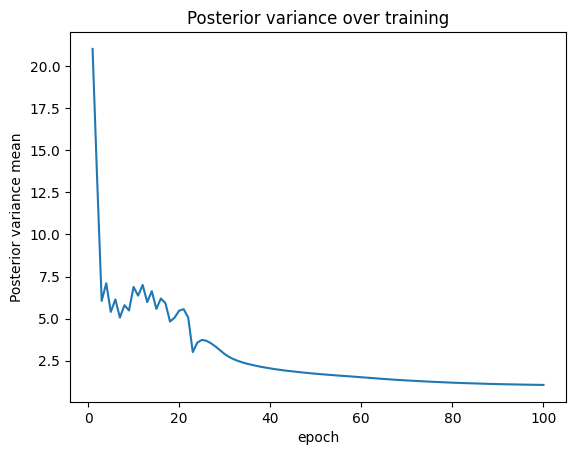

[Z=100] PPC=0.531, KL=1165.4, Var=1.0628

===== Running latent_dim = 200 =====
[Epoch 10/100] beta=0.333 loss=-290969.35 KL=-305580.34 var=5.5581
[Epoch 20/100] beta=0.667 loss=-127905.17 KL=-142287.72 var=4.8958
[Epoch 30/100] beta=1.000 loss=26263.88 KL=12337.57 var=3.0351
[Epoch 40/100] beta=1.000 loss=19269.62 KL=6298.84 var=2.0194
[Epoch 50/100] beta=1.000 loss=16730.24 KL=4272.97 var=1.7192
[Epoch 60/100] beta=1.000 loss=15087.30 KL=3192.91 var=1.5469
[Epoch 70/100] beta=1.000 loss=13661.41 KL=2533.83 var=1.4039
[Epoch 80/100] beta=1.000 loss=12747.39 KL=2088.83 var=1.3057
[Epoch 90/100] beta=1.000 loss=12008.18 KL=1722.25 var=1.2425
[Epoch 100/100] beta=1.000 loss=11409.93 KL=1407.05 var=1.2010


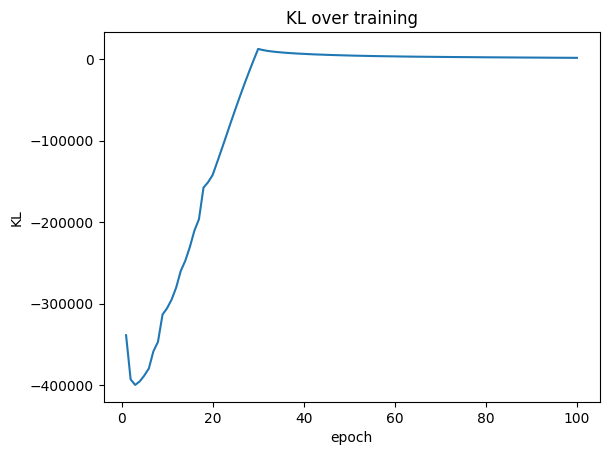

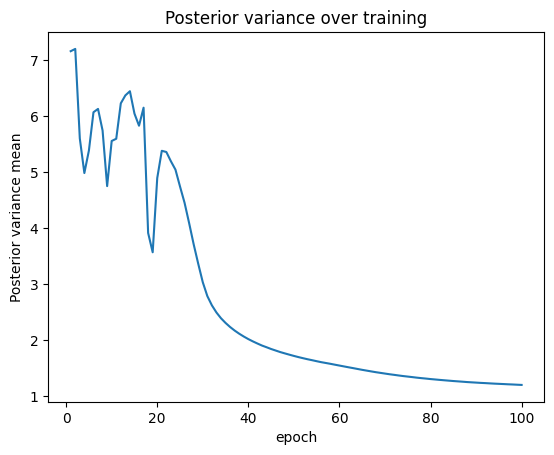

[Z=200] PPC=0.543, KL=1407.1, Var=1.2010

===== Running latent_dim = 500 =====
[Epoch 10/100] beta=0.333 loss=-736668.63 KL=-752705.00 var=4.9728
[Epoch 20/100] beta=0.667 loss=-339835.51 KL=-354363.41 var=4.2165
[Epoch 30/100] beta=1.000 loss=40566.14 KL=26860.99 var=2.6340
[Epoch 40/100] beta=1.000 loss=28882.17 KL=15169.57 var=1.9220
[Epoch 50/100] beta=1.000 loss=23566.75 KL=10315.23 var=1.6650
[Epoch 60/100] beta=1.000 loss=19776.56 KL=6975.34 var=1.5141
[Epoch 70/100] beta=1.000 loss=17128.65 KL=4786.22 var=1.4197
[Epoch 80/100] beta=1.000 loss=15247.28 KL=3420.29 var=1.3596
[Epoch 90/100] beta=1.000 loss=13862.26 KL=2616.99 var=1.3177
[Epoch 100/100] beta=1.000 loss=12803.23 KL=2104.08 var=1.2805


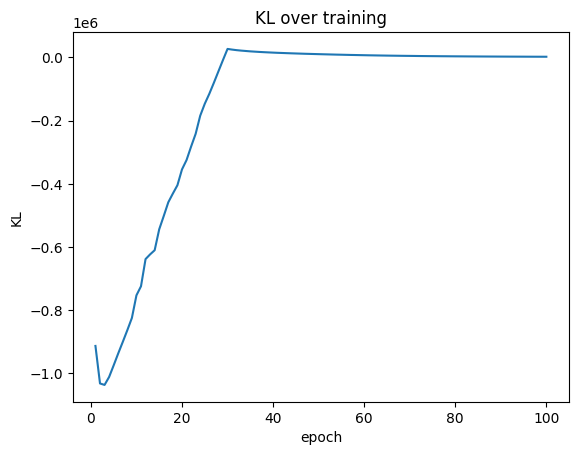

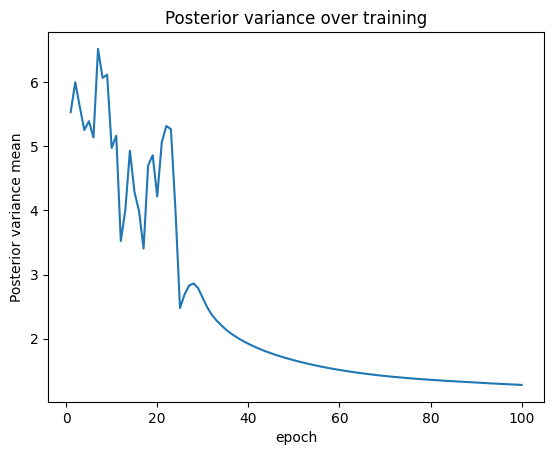

[Z=500] PPC=0.580, KL=2104.1, Var=1.2805


In [ ]:
results = []

model_kwargs = dict(
    input_dim=A_try.shape[2],
    x_dim=X_tensor.shape[2],
    hidden_dim=128,
)

ppc_kwargs = dict(
    num_z_samples=30,
    batch_size=128,
)

for zdim in latent_grid:
    print(f"\n===== Running latent_dim = {zdim} =====")
    out = run_single_latent_experiment(
        latent_dim=zdim,
        A=A_try,
        X=X_tensor,
        obs_mask=obs_mask,
        model_kwargs=model_kwargs,
        train_kwargs=train_kwargs,
        ppc_kwargs=ppc_kwargs,
        seed=0,
    )
    results.append(out)

    print(
        f"[Z={zdim}] PPC={out['ppc_score']:.3f}, "
        f"KL={out['summary']['final_kl']:.1f}, "
        f"Var={out['summary']['final_post_var']:.4f}"
    )


In [ ]:
summary_df = pd.DataFrame([r["summary"]["summary"] for r in results])
summary_df

,latent_dim,ppc_score,final_kl,final_post_var,num_epochs,lr,anneal,warmup_epochs,seed
0,10,0.295586,930.787660,0.514862,100,0.0001,linear,30,0
1,50,0.283483,1008.185339,0.895697,100,0.0001,linear,30,0
2,100,0.299289,1165.397689,1.062776,100,0.0001,linear,30,0
3,200,0.324375,1407.052028,1.201035,100,0.0001,linear,30,0
4,500,0.334375,2104.077793,1.280464,100,0.0001,linear,30,0


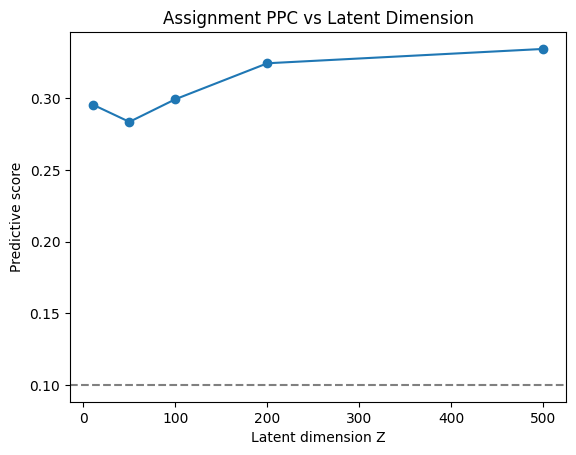

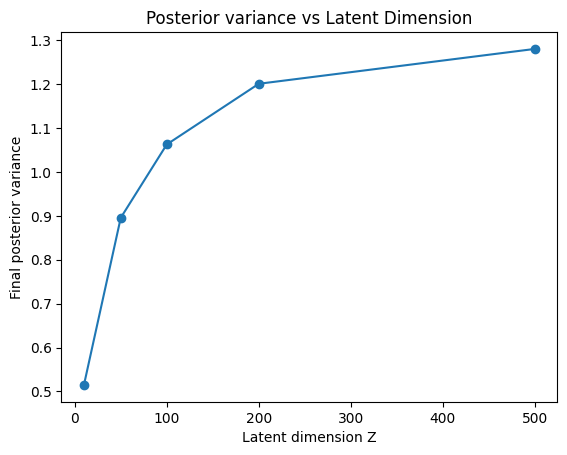

In [ ]:
plt.figure()
plt.plot(summary_df["latent_dim"], summary_df["ppc_score"], marker="o")
plt.axhline(0.1, linestyle="--", color="gray")
plt.xlabel("Latent dimension Z")
plt.ylabel("Predictive score")
plt.title("Assignment PPC vs Latent Dimension")
plt.show()


plt.figure()
plt.plot(summary_df["latent_dim"], summary_df["final_post_var"], marker="o")
plt.xlabel("Latent dimension Z")
plt.ylabel("Final posterior variance")
plt.title("Posterior variance vs Latent Dimension")
plt.show()


In [ ]:
def save_dvae_run(out, base_dir="results"):
    """
    Save one DVAE run (one latent_dim) in a reproducible, paper-friendly way.
    """
    latent_dim = out["latent_dim"]
    save_dir = os.path.join(base_dir, f"latent_{latent_dim}")
    os.makedirs(save_dir, exist_ok=True)

    # ---------- 1. training metrics ----------
    out["train_df"].to_csv(
        os.path.join(save_dir, "metrics.csv"),
        index=False
    )

    # ---------- 2. PPC results ----------
    np.savez_compressed(
        os.path.join(save_dir, "ppc.npz"),
        t_obs=out["t_obs"].cpu().numpy(),
        t_rep=out["t_rep"].cpu().numpy(),
        ppc_score=np.array(out["ppc_score"]),
    )

    # ---------- 3. model checkpoint ----------
    torch.save(
        {
            "model_state_dict": out["model"].state_dict(),
            "pyro_param_store": pyro.get_param_store().get_state(),
            "latent_dim": latent_dim,
        },
        os.path.join(save_dir, "model.pt")
    )

    # ---------- 4. summary / metadata ----------
    with open(os.path.join(save_dir, "summary.json"), "w") as f:
        json.dump(
            {
                "latent_dim": latent_dim,
                "ppc_score": float(out["ppc_score"]),
                "summary": out.get("summary", {}),
            },
            f,
            indent=2
        )

    print(f"Saved results to {save_dir}")


save_dvae_run(out, base_dir="/content/drive/MyDrive/PMML_Project/experiments")


Saved results to /content/drive/MyDrive/PMML_Project/experiments/latent_500


In [ ]:
for out in results:
    save_dvae_run(out, base_dir="/content/drive/MyDrive/PMML_Project/experiments")

Saved results to /content/drive/MyDrive/PMML_Project/experiments/latent_10
Saved results to /content/drive/MyDrive/PMML_Project/experiments/latent_50
Saved results to /content/drive/MyDrive/PMML_Project/experiments/latent_100
Saved results to /content/drive/MyDrive/PMML_Project/experiments/latent_200
Saved results to /content/drive/MyDrive/PMML_Project/experiments/latent_500


In [ ]:
import json


def load_dvae_run(
    latent_dim,
    base_dir="/content/drive/MyDrive/PMML_Project/experiments",
    model_class=None,
    model_kwargs=None,
    device="cpu",
):
    """
    Load one DVAE run saved by save_dvae_run().

    Parameters
    ----------
    latent_dim : int
        Latent dimension to load (corresponds to latent_{dim}/).
    model_class : nn.Module class, optional
        DVAE model class definition (required if loading model).
    model_kwargs : dict, optional
        Arguments needed to re-instantiate the model.
    device : str
        'cpu' or 'cuda'

    Returns
    -------
    dict with keys:
        train_df, t_obs, t_rep, ppc_score,
        model (optional), summary
    """

    run_dir = os.path.join(base_dir, f"latent_{latent_dim}")

    # ---------- 1. training metrics ----------
    train_df = pd.read_csv(os.path.join(run_dir, "metrics.csv"))

    # ---------- 2. PPC results ----------
    ppc = np.load(os.path.join(run_dir, "ppc.npz"))
    t_obs = torch.tensor(ppc["t_obs"], device=device)
    t_rep = torch.tensor(ppc["t_rep"], device=device)
    ppc_score = float(ppc["ppc_score"])

    # ---------- 3. summary ----------
    with open(os.path.join(run_dir, "summary.json"), "r") as f:
        summary = json.load(f)

    result = {
        "latent_dim": latent_dim,
        "train_df": train_df,
        "t_obs": t_obs,
        "t_rep": t_rep,
        "ppc_score": ppc_score,
        "summary": summary,
    }

    # ---------- 4. model (optional) ----------
    if model_class is not None:
        checkpoint = torch.load(
            os.path.join(run_dir, "model.pt"),
            map_location=device,
            weights_only=False
        )

        model = model_class(**model_kwargs)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.to(device)
        model.eval()

        pyro.get_param_store().set_state(
            checkpoint["pyro_param_store"]
        )

        result["model"] = model

    return result


In [ ]:
results = []

for latent_dim in latent_grid:

  out = load_dvae_run(
      latent_dim=latent_dim,
      base_dir="/content/drive/MyDrive/PMML_Project/experiments",
      model_class=PyroDVAE,          # your DVAE class
      model_kwargs={
          "input_dim": A_try.shape[2],
          "latent_dim": latent_dim,
          "hidden_dim": 128,
          "x_dim": X_tensor.shape[2],
      },
      device="cuda"
  )

  results.append(out)


In [ ]:
results[0].keys()

dict_keys(['latent_dim', 'train_df', 't_obs', 't_rep', 'ppc_score', 'summary', 'model'])

In [ ]:
ppc_kwargs = dict(
    num_z_samples=30,
    batch_size=128,
)

for i in range(len(results)):
    out = results[i]
    print(f"Latent dimension: {out['latent_dim']}")
    model_obj = out["model"]
    train_df = out["train_df"]

    t_obs, t_rep = ppc_discrepancy_per_user(
        model_obj=model_obj,
        A=A_held,
        X=X_held,
        obs_mask=obs_mask,
        **ppc_kwargs,
    )

    score = predictive_score(t_obs, t_rep)
    print(f"PPC score: {score}")
    out["ppc_score"] = score
    out['summary']['summary']['ppc_score'] = score

    out['t_obs'] = t_obs
    out['t_rep'] = t_rep
    results[i] = out

Latent dimension: 10
PPC score: 0.29558610916137695
Latent dimension: 50
PPC score: 0.2834833264350891
Latent dimension: 100
PPC score: 0.29928889870643616
Latent dimension: 200
PPC score: 0.3243750035762787
Latent dimension: 500
PPC score: 0.3343749940395355


In [ ]:
for i in range(len(results)):
    out = results[i]
    print(f"Latent dimension: {out['summary']}")

Latent dimension: {'latent_dim': 10, 'ppc_score': 0.5180027484893799, 'summary': {'latent_dim': 10, 'ppc_score': 0.5180027484893799, 'final_kl': 930.7876599900266, 'final_post_var': 0.5148624113406414, 'num_epochs': 100, 'lr': 0.0001, 'anneal': 'linear', 'warmup_epochs': 30, 'seed': 0}}
Latent dimension: {'latent_dim': 50, 'ppc_score': 0.526283323764801, 'summary': {'latent_dim': 50, 'ppc_score': 0.526283323764801, 'final_kl': 1008.1853390957447, 'final_post_var': 0.8956971066358805, 'num_epochs': 100, 'lr': 0.0001, 'anneal': 'linear', 'warmup_epochs': 30, 'seed': 0}}
Latent dimension: {'latent_dim': 100, 'ppc_score': 0.5310527682304382, 'summary': {'latent_dim': 100, 'ppc_score': 0.5310527682304382, 'final_kl': 1165.397689494681, 'final_post_var': 1.0627762588626104, 'num_epochs': 100, 'lr': 0.0001, 'anneal': 'linear', 'warmup_epochs': 30, 'seed': 0}}
Latent dimension: {'latent_dim': 200, 'ppc_score': 0.5433861017227173, 'summary': {'latent_dim': 200, 'ppc_score': 0.5433861017227173, 

# Outcome Estimation

In [ ]:
import os
import json
import sys, importlib

root = '/content/drive/MyDrive/PMML_Project'
data_path = root +"/Dataset/Click_Subsample"
utils_path = root +"/utils"
model_dir = "/content/drive/MyDrive/PMML_Project/experiments/dvae_dynamic_masked_20251216_100022"
path_to_ckpt = model_dir + "/model_state_dict.pt"

### Read Model

In [ ]:
import torch.nn.functional as F
from sklearn.linear_model import Ridge, SGDRegressor, QuantileRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import constraints
from torch.serialization import add_safe_globals

add_safe_globals([constraints._Real])

ckpt = torch.load(path_to_ckpt)


In [ ]:
if root not in sys.path:
    sys.path.insert(0, root)

if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

print("✅ Imports successful!")

sys.path.append("/content/drive/MyDrive/PMML_Project")

import model
importlib.reload(model)

print("PyroDVAE" in dir(model))

from model import PyroDVAE


✅ Imports successful!
True


In [ ]:
def load_run(
    run_dir,
    model_class,
    device="cuda",
    load_rng_state=False,
):
    """
    Load everything needed for:
    - posterior Z reuse
    - PPC re-evaluation
    - downstream causal estimation
    """

    # --------------------------------------------------
    # 1) Load configs
    # --------------------------------------------------
    with open(os.path.join(run_dir, "model_config.json"), "r") as f:
        model_config = json.load(f)

    # --------------------------------------------------
    # 2) Reconstruct model architecture
    # --------------------------------------------------
    model = model_class(**model_config).to(device)
    model.load_state_dict(
        torch.load(os.path.join(run_dir, "model_state_dict.pt"), map_location=device)
    )

    # --------------------------------------------------
    # 3) Load Pyro param store (CRITICAL)
    # --------------------------------------------------
    pyro.clear_param_store()
    pyro.get_param_store().load(os.path.join(run_dir, "pyro_param_store.pt"))

    model.eval()

    # --------------------------------------------------
    # 4) Load obs_mask
    # --------------------------------------------------
    obs_mask = torch.load(
        os.path.join(run_dir, "obs_mask.pt"),
        map_location=device
    )

    # --------------------------------------------------
    # 5) Load posterior Z mean
    # --------------------------------------------------
    Z_mean = torch.load(
        os.path.join(run_dir, "posterior_Z_mean.pt"),
        map_location=device
    )

    # --------------------------------------------------
    # 6) Load RNG state (optional)
    # --------------------------------------------------
    if load_rng_state and os.path.exists(os.path.join(run_dir, "rng_state.pt")):
        rng_state = torch.load(os.path.join(run_dir, "rng_state.pt"))
        torch.set_rng_state(rng_state["cpu"])
        torch.cuda.set_rng_state_all(rng_state["cuda"])

    return {
        "model": model,
        "obs_mask": obs_mask,
        "Z_mean": Z_mean,          # (U, T, latent_dim)
        "model_config": model_config,
    }


In [ ]:
loaded = load_run(
    run_dir="/content/drive/MyDrive/PMML_Project/experiments/dvae_dynamic_masked_20251219_230427",
    model_class=PyroDVAE,
    device="cpu",
    load_rng_state=False,
)

In [ ]:
Z_tensor = loaded["Z_mean"]   # use directly in MSM / g-formula / outcome regression
model_obj = loaded["model"]
obs_mask = loaded["obs_mask"]
cfg = loaded["model_config"]
tran_df = pd.read_csv("/content/drive/MyDrive/PMML_Project/experiments/dvae_dynamic_masked_20251219_230427/train_logs.csv")
tran_df

,epoch,beta,svi_loss,elbo,recon_nll,kl,kl_weighted,post_var_mean
0,1,0.033333,3.138523e+06,-3.116536e+06,3.757107e+06,-640571.312500,-21352.377083,1.080975
1,2,0.066667,8.969501e+05,-8.515305e+05,1.500186e+06,-648655.309840,-43243.687323,10.293163
2,3,0.100000,-3.436125e+05,3.546198e+05,3.691638e+05,-723783.547872,-72378.354787,4.708705
3,4,0.133333,-5.897561e+05,5.942986e+05,1.394912e+05,-733789.816489,-97838.642199,4.418065
4,5,0.166667,-6.531424e+05,6.564908e+05,7.411810e+04,-730608.847074,-121768.141179,4.282203
...,...,...,...,...,...,...,...,...
145,146,1.000000,2.578646e+04,-2.577774e+04,2.198641e+04,3791.335106,3791.335106,1.093521
146,147,1.000000,2.568413e+04,-2.569708e+04,2.193823e+04,3758.855053,3758.855053,1.089130
147,148,1.000000,2.566565e+04,-2.564506e+04,2.194027e+04,3704.784574,3704.784574,1.084895
148,149,1.000000,2.557791e+04,-2.555785e+04,2.184250e+04,3715.355053,3715.355053,1.080617


### Outcome Model

In [ ]:
from outcome import build_Y_tensors_from_buy_day, build_purchase_tables, plot_beta_distributions, analyze_top_categories
from outcome import estimate_outcome_model_fast, estimate_outcome_model_uncorrected, compare_deconfounding
from outcome import estimate_temporal_population_uncorrected, estimate_dual_causal_effects
from outcome import estimate_temporal_population_effects


In [ ]:
A_tensor = torch.as_tensor(A_tensor, dtype=torch.float32, device='cuda')
X_tensor = torch.as_tensor(X_tensor, dtype=torch.float32, device=A_tensor.device)
obs_mask = torch.as_tensor(obs_mask, dtype=torch.bool, device=A_tensor.device)
A_tensor.shape

torch.Size([12000, 9, 2896])

In [ ]:
A_tensor.device

device(type='cuda', index=0)

In [ ]:
import pyro.poutine as poutine

model_obj.to(device=A_tensor.device)
model_obj.eval()
obs_mask = obs_mask.to(device=A_tensor.device)

with torch.no_grad():
    guide_trace = poutine.trace(model_obj.guide).get_trace(
        A_tensor,
        X_tensor,
        obs_mask=obs_mask
    )


In [ ]:
buy_day_b = build_purchase_tables(behaviors_buy[behaviors_buy['date']>'2017-05-04'], binary=True, day_col="date")
buy_day = build_purchase_tables(behaviors_buy[behaviors_buy['date']>'2017-05-04'], binary=False, day_col="date")
day_list = sorted(buy_day["date"].unique())

Y_day_b, Y_next_b, Y_cum_b = build_Y_tensors_from_buy_day(buy_day_b, users_all, day_list)
Y_day, Y_next, Y_cum = build_Y_tensors_from_buy_day(buy_day, users_all, day_list)

### Outcome Estimation

In [ ]:
A = np.asarray(A_tensor)
X = np.asarray(X_tensor)
Z = np.asarray(Z_tensor)
Y_next = np.asarray(Y_next)
Y_cum  = np.asarray(Y_cum)
A_try = A_tensor.clone()
A_try = torch.clamp(A_try, max=15.0)


In [ ]:
device = A_tensor.device  # or torch.device("cuda")

X_tensor = X_tensor.to(device)
Z_tensor = Z_tensor.to(device)
Y_cum = torch.as_tensor(Y_cum, dtype=torch.float32, device=A_tensor.device)
Y_next = torch.as_tensor(Y_next, dtype=torch.float32, device=A_tensor.device)

A = A_try[:, :-1]
Z = Z_tensor[:, :-1]
X = X_tensor[:, :-1]


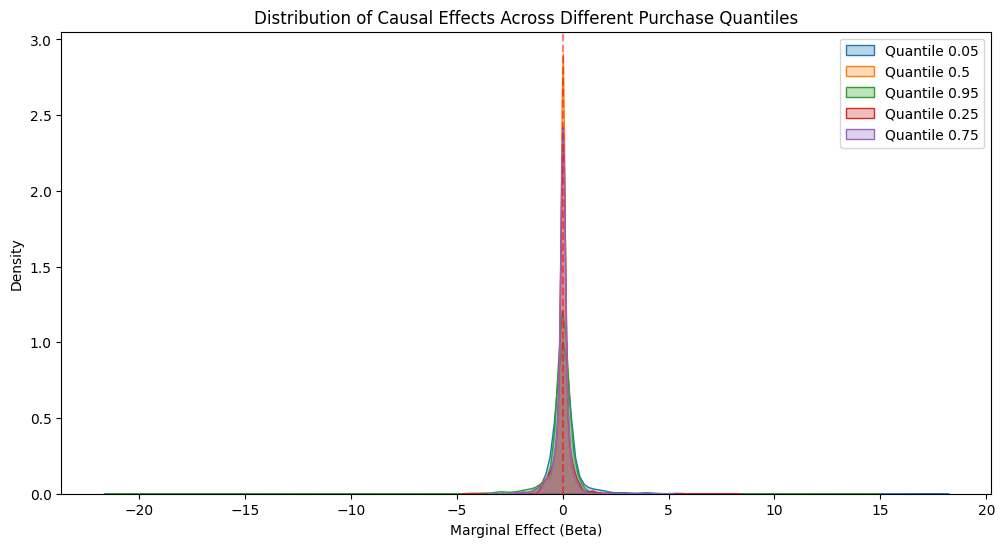

In [ ]:
betas_dict = {0.05: beta_q5, 0.5: beta_q50, 0.95: beta_q95, 0.25: beta_q25, 0.75: beta_q75}

plot_beta_distributions(betas_dict)

In [ ]:
A_mean = A.mean(dim=(0, 1))

A_mean_np = A_mean.cpu().numpy()

### Temporal Structure

In [ ]:
Y_next = torch.tensor(Y_next, dtype=torch.float32, device=A_tensor.device)

beta_inst_q95, beta_cum_q95 = estimate_dual_causal_effects(A, Z, X, Y_next, model_obj.emission, quantile=0.95)

/tmp/ipython-input-2847340679.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_next = torch.tensor(Y_next, dtype=torch.float32, device=A_tensor.device)


In [ ]:
beta_inst_q75, beta_cum_q75 = estimate_dual_causal_effects(A, Z, X, Y_next, model_obj.emission, quantile=0.75)
beta_inst_q50, beta_cum_q50 = estimate_dual_causal_effects(A, Z, X, Y_next, model_obj.emission, quantile=0.5)
beta_inst_q25, beta_cum_q25 = estimate_dual_causal_effects(A, Z, X, Y_next, model_obj.emission, quantile=0.25)
beta_inst_q05, beta_cum_q05 = estimate_dual_causal_effects(A, Z, X, Y_next, model_obj.emission, quantile=0.05)


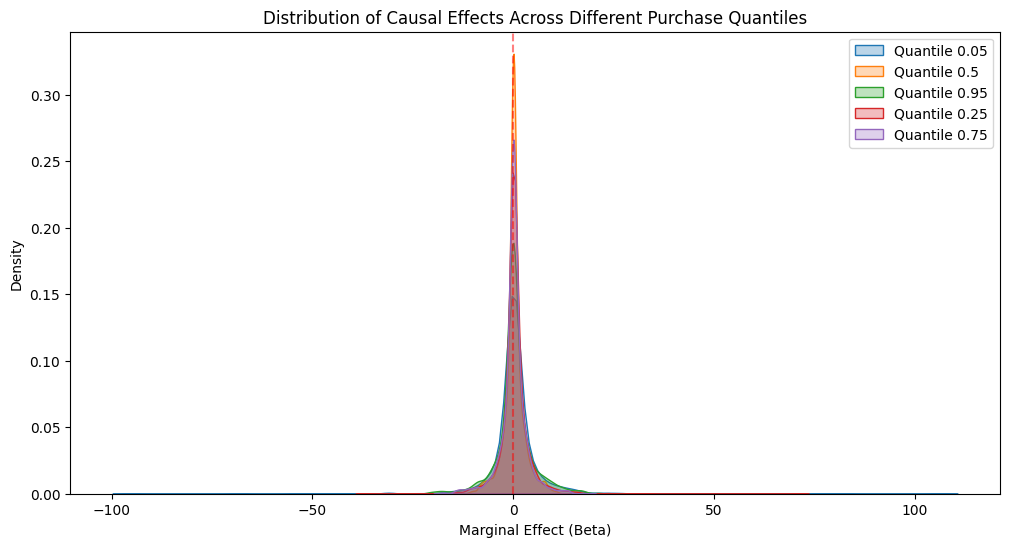

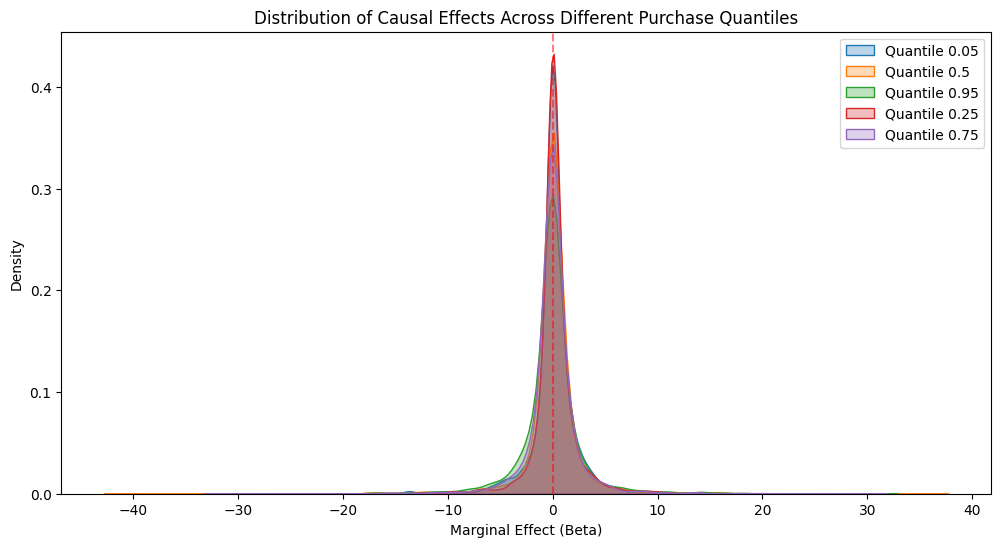

In [ ]:
betas_dict_inst = {0.05: beta_inst_q05, 0.5: beta_inst_q50, 0.95: beta_inst_q95, 0.25: beta_inst_q25, 0.75: beta_inst_q75}
betas_dict_cum = {0.05: beta_cum_q05, 0.5: beta_cum_q50, 0.95: beta_cum_q95, 0.25: beta_cum_q25, 0.75: beta_cum_q75}

plot_beta_distributions(betas_dict_inst)
plot_beta_distributions(betas_dict_cum)

In [ ]:
beta_inst, beta_cum = estimate_temporal_population_effects(A, Z, X, Y_next, model_obj.emission)


Step 1: Performing daily deconfounding...
Step 2: Estimating Instantaneous Effects...
Step 3: Estimating Cumulative Effects...


In [ ]:
beta_inst_unconf, beta_cum_unconf = estimate_temporal_population_uncorrected(A, X, Y_next)

Step 1: Performing daily residualization (Uncorrected - No Z)...


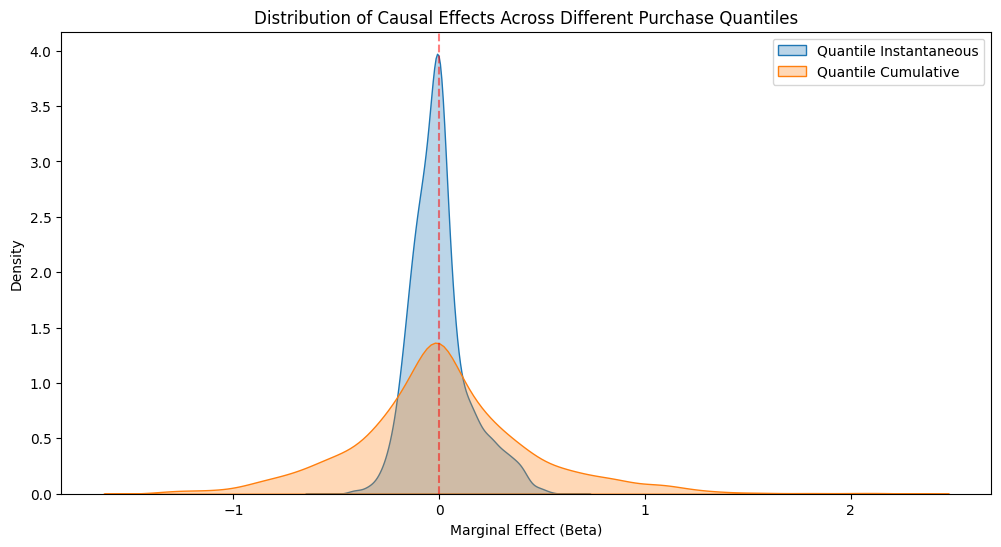

/tmp/ipython-input-2645295698.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_impact.head(top_n), x='Total_Impact', y='Category_ID', orient='h', palette='magma')


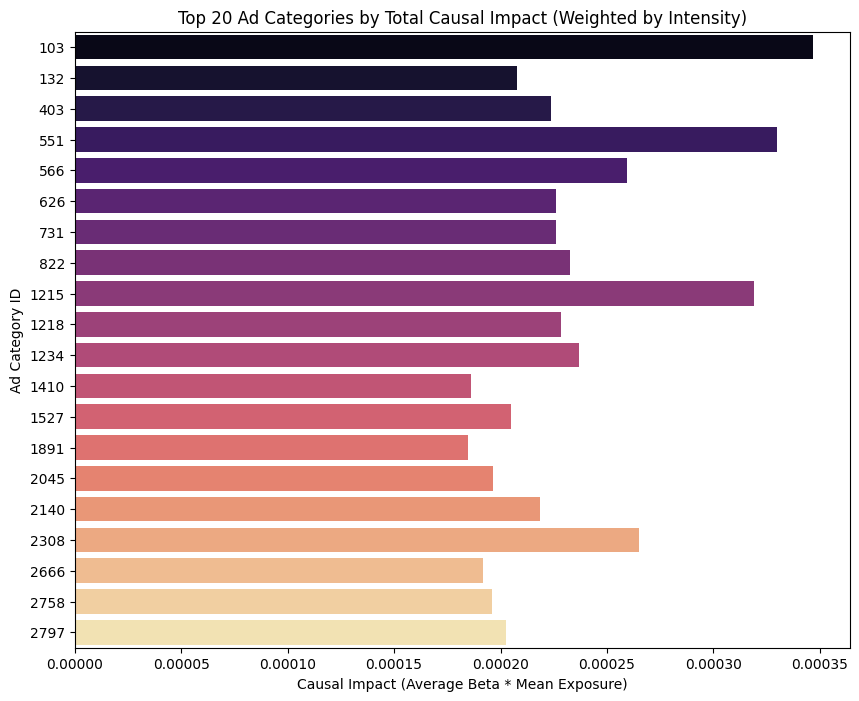

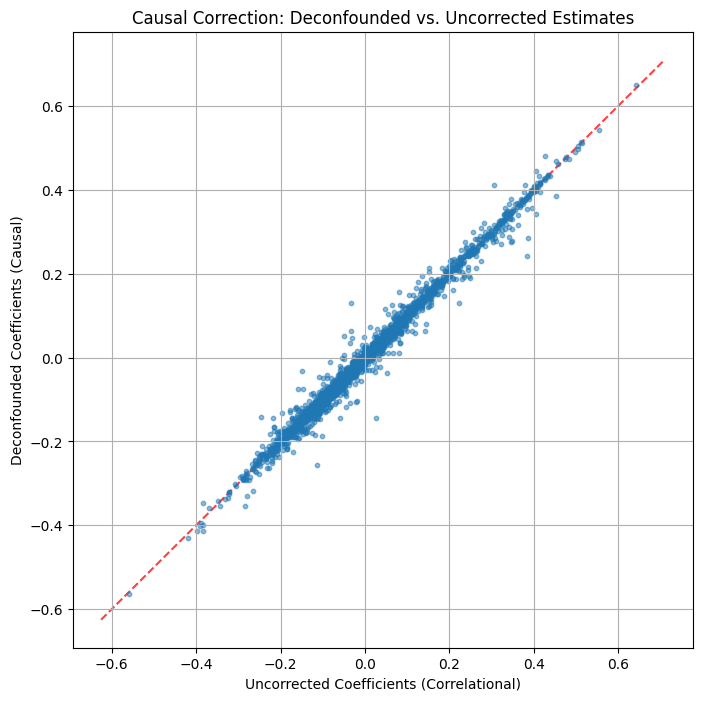

Average coefficient adjustment: 0.00912042005746364


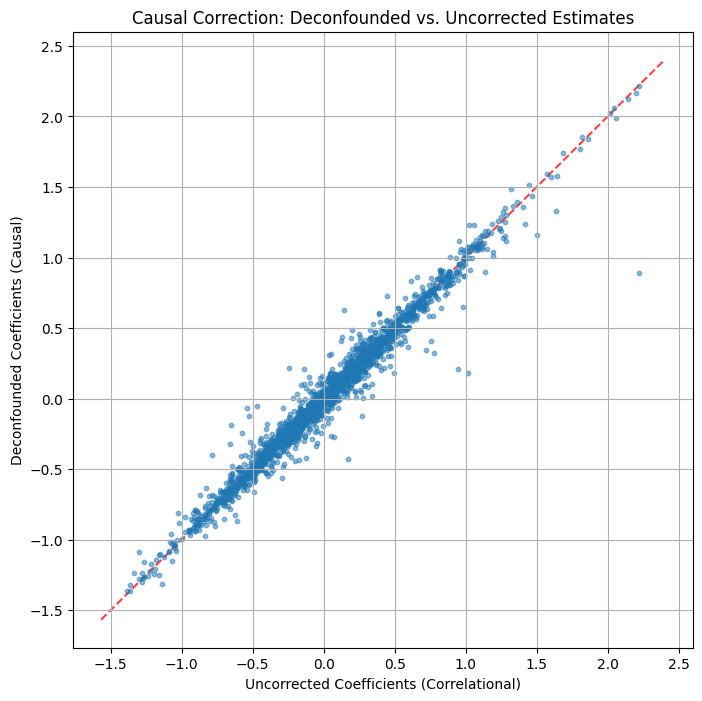

Average coefficient adjustment: 0.04083207132268488


In [ ]:

# 1. check distribution
plot_beta_distributions({
    "Instantaneous": beta_inst,
    "Cumulative": beta_cum
})

# 2. find top category
top_cum_df = analyze_top_categories({"Cumulative": beta_cum}, A_mean=A.mean(dim=(0,1)))

# 3. compare effects
compare_deconfounding(beta_inst, beta_inst_unconf)
compare_deconfounding(beta_cum, beta_cum_unconf)